<a href="https://colab.research.google.com/github/brandon-baek/Youtube-Comment-Sentiment-Detection-Project/blob/main/YouTube_Comment_Sentiment_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Youtube Comment Sentiment Detection Project

This project displays a simple Neural Network made with Keras trained on Youtube comments for text classification. It detects textual sentiment.

# Prerequisites

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

---

For collecting embeddings, SentenceTransformer all-MiniLM-L6-v2 will be used.

Using a GPU is reccomended.

---

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

emb = SentenceTransformer('all-MiniLM-L6-v2', device=device)

Using: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Data Prep

---

Download Dataset at https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset

The Pandas library automatically defaults nan while downloading the dataset. For this reason, generating embeddings faces errors in the future. So "keep_default_na" is set to false.

---

In [ ]:
dataset = pd.read_csv('/content/YoutubeCommentsDataSet.csv', keep_default_na=False)

dataset.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


---

First, the X_data and the y_data is extracted from the "Comment" and "Sentiment" columns of the dataset. Both are converted to lists for easier manipulation.

Second, the X_data is encoded and the embeddings for all examples are generated.

Third, the y_data takes the "negative", "neutral", and "positive" strings and maps them to either 0, 1, or 2.

---

In [ ]:
X_data = dataset['Comment'].tolist()
y_data = dataset['Sentiment'].tolist()

X_data = emb.encode(X_data, show_progress_bar=True, num_workers=4)

sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_data = dataset['Sentiment'].map(sentiment_mapping).values
y_data = to_categorical(y_data, num_classes=3)

Batches:   0%|          | 0/576 [00:00<?, ?it/s]

---

The data is split into train and test splits. The data is not shuffled and the testing data is exactly 10% of the original data.

---

In [ ]:
X_train, X_test, y_train, y_test = (train_test_split(X_data, y_data, test_size=0.1, shuffle=False))

# Neural Network

## Model Architecture

In [ ]:
model = Sequential()
model.add(Input(shape=(384,)))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Training/Fitting

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=3, validation_split=0.1)

Epoch 1/3
932/932 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6184 - loss: 0.9354 - val_accuracy: 0.7568 - val_loss: 0.5620
Epoch 2/3
932/932 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7530 - loss: 0.5692 - val_accuracy: 0.7459 - val_loss: 0.5793
Epoch 3/3
932/932 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7706 - loss: 0.5292 - val_accuracy: 0.7791 - val_loss: 0.5334


### Training History Graph

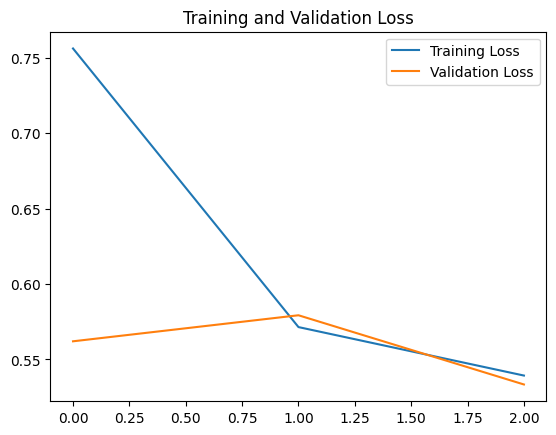

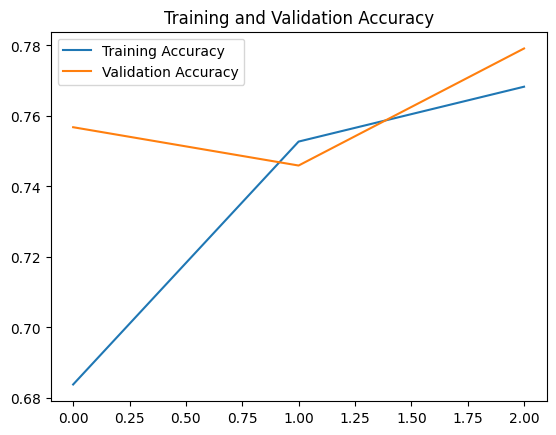

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluation

---

Evaluating the model on the test datas and just having fun.

---

In [ ]:
numeric_sentiment_mapping = {0: 'Negative', 1:'Neutral', 2:'Positive'}

---

**Error Rate**

---

In [ ]:
errors = 0
total = 0
for idx, xex in enumerate(model.predict(X_test), start=0):
    if xex.argmax() != y_test[idx].argmax():
        errors += 1
    total += 1

print('Error percent: ' + str((errors / total) * 100) + '%')
print('Correct percent: ' + str(((total - errors) / total) * 100) + '%')

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Error percent: 18.033677349266704%
Correct percent: 81.96632265073329%


---

**Test Examples**

---

In [ ]:
for idx, xex in enumerate(model.predict(X_test)[:5], start=0):
    print('---')
    print('Text:', dataset['Comment'].tolist()[-(len(dataset) // 10):][idx])
    print('Prediction Probabilities:', xex)
    print(f'Prediction: {xex.argmax()} ({numeric_sentiment_mapping[xex.argmax()]})')
    print(f'Actual: {np.argmax(y_test[idx])} ({numeric_sentiment_mapping[np.argmax(y_test[idx])]})')
    print('---\n')

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
---
Text: dude the rock was good in this movie i ain’t even see him 
Prediction Probabilities: [0.11055917 0.8358315  0.0536093 ]
Prediction: 1 (Neutral)
Actual: 1 (Neutral)
---

---
Text: i like when they said you got nothing to trade are you a good fighter  lol good transition
Prediction Probabilities: [0.35329956 0.28793347 0.358767  ]
Prediction: 2 (Positive)
Actual: 2 (Positive)
---

---
Text: whos your favorite character on the bear chef
Prediction Probabilities: [0.0274175  0.20337757 0.7692049 ]
Prediction: 2 (Positive)
Actual: 2 (Positive)
---

---
Text: i know that you have other things going on but i seriously miss the regularity of your videos during the height of the pandemic you j kenji lopezalt marions kitchen nicki positano and a few others are what got me through the days weeks of quarantining alone and food shortages the fridge in your old kitchen gave me hope that i could shop and cook for good food and make it work in my ancien

---

An observation can be made where in the text instance, "i can’t tell you enough how excited i get every time you release a new video i’m actually making your infamous stew today …and probably this chicken piccata recipe tomorrow," the model predicts positive while the actual is neutral. From my perspective, I believe this should be positive, as my model stated. However sentiment is completely subjective, meaning the judgement of the y_test maybe more correct. This shows how the evaluation results from above reveals a vulnerability.

---

---

**Messing around**

---

In [ ]:
text = "Hello"

sentiment_value = model.predict(emb.encode([text], convert_to_numpy=True)).argmax()

print(numeric_sentiment_mapping[sentiment_value])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Neutral
